# Forecast Police Service Calls

***

## Libraries

In [2]:
import boto3
import sagemaker
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import plotly.express as px

## Variables

In [3]:
db_name = "sdpd"
Bucket = 'sdpd-bucket' 
region = boto3.Session().region_name
s3_staging_dir = "s3://{}/athena/staging".format(Bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
role = sagemaker.get_execution_role()
s3 = boto3.client('s3') # Create an S3 client
s3_resource = boto3.resource('s3') # Create an S3 resource

print('S3_staging_dir - > ',s3_staging_dir)
print('Conn - > ',conn)
print('Region - > ',region)


S3_staging_dir - >  s3://sdpd-bucket/athena/staging
Conn - >  <pyathena.connection.Connection object at 0x7fc70105d750>
Region - >  us-east-1


## Functions

In [4]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=99):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

## Retrive Data

In [11]:
Stops_Hourly = """SELECT * FROM {}.{}
    order by date_time desc
     LIMIT 1000
     """.format(
    db_name, 'calls_hour'
)

print(Stops_Hourly)

SELECT * FROM sdpd.calls_hour
    order by date_time desc
     LIMIT 1000
     


In [12]:
Call_Data = """SELECT * FROM {}.{}
order by date_time desc
     LIMIT 500
     """.format(
    db_name, 'Call_Data'
)

print(Call_Data)

SELECT * FROM sdpd.Call_Data
order by date_time desc
     LIMIT 500
     


In [21]:
calls = pd.read_sql(Stops_Hourly, conn)
calls['date_time'] = pd.to_datetime(calls['date_time'])
calls['count'] = calls['count'].astype(int)
calls.set_index('date_time', inplace = True)

In [22]:
#calls_ts = calls['count']
calls

,date_time,count,year,hour
0,2023-03-24 23:00:00+00:00,20,2023,23
1,2023-03-24 22:00:00+00:00,60,2023,22
2,2023-03-24 21:00:00+00:00,44,2023,21
3,2023-03-24 20:00:00+00:00,62,2023,20
4,2023-03-24 19:00:00+00:00,46,2023,19
...,...,...,...,...
995,2023-02-11 12:00:00+00:00,2,2023,12
996,2023-02-11 11:00:00+00:00,3,2023,11
997,2023-02-11 10:00:00+00:00,0,2023,10
998,2023-02-11 09:00:00+00:00,4,2023,9


In [23]:
test_size = 100

calls_train = calls[:-test_size]
calls_test = calls[-test_size:]

### Timeseries

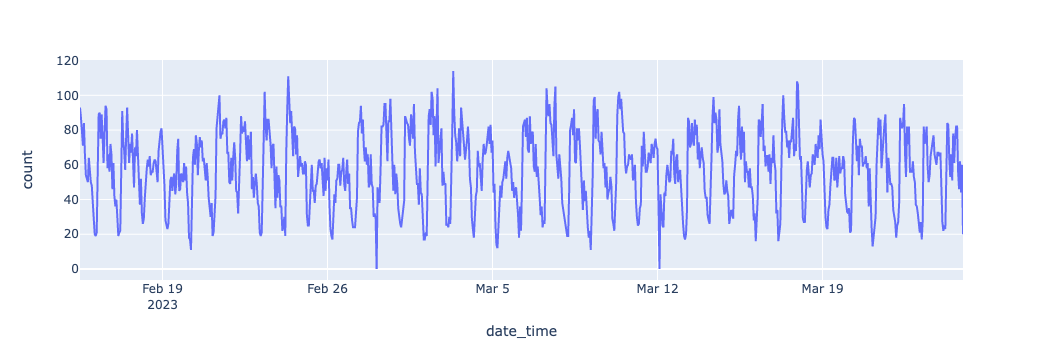

In [25]:
fig = px.line(calls_train, x='date_time', y="count")
fig.show()